In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

import glob
import sys
import re

sys.path.append('../src-py/')
pd.set_option('display.max_colwidth', None)

In [2]:
kialo_json = json.load(open('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/kialo_data/kialo_corpus.json'))

In [3]:
import random

In [12]:
kialo_ds = []
added_counters = set()
for item in kialo_json:
    debate_id = item['id'].split('.')[0]
    premises = [x['text'] for x in random.sample(item['pro'], 5)] if len(item['pro']) > 5 else [x['text'] for x in item['pro']]
    if len(premises) < 3:
        continue
    #if item['text'] in added_counters: #this to avoide having claim in the input and the output
    #    continue
    for counter in item['con']:
        kialo_ds.append({
            'debate_id': debate_id,
            'conclusion_id': item['id'],
            'conclusion_text': item['text'],
            'premises': premises,
            'counter' : counter['text']
        })
        #added_counters.add(counter['text'])

kialo_df = pd.DataFrame(kialo_ds)

In [13]:
#clean up kialo df from links
kialo_df['conclusion_text'] = kialo_df.conclusion_text.apply(lambda x: re.sub(r"\[(.*?)\]([^\s]+)", r"\1", x))
kialo_df['premises'] = kialo_df.premises.apply(lambda premises: [re.sub(r"\[(.*?)\]([^\s]+)", r"\1", x) for x in premises])
kialo_df['counter'] = kialo_df.counter.apply(lambda x: re.sub(r"\[(.*?)\]([^\s]+)", r"\1", x))

kialo_df['conclusion_text'] = kialo_df.conclusion_text.apply(lambda x: re.sub(r'http\S+', ' ', x))
kialo_df['premises'] = kialo_df.premises.apply(lambda premises: [re.sub(r'http\S+', ' ', x) for x in premises])
kialo_df['counter'] = kialo_df.counter.apply(lambda x: re.sub(r'http\S+', ' ', x))

In [14]:
kialo_df.sample(10).head(n=10)

,debate_id,conclusion_id,conclusion_text,premises,counter
46623,2408,2408.221,"The construction of these memorials are done to put forward ideologies. For example the individuals are posed heroically, with positive messages.","[Monuments carry with them the connotation of honoring the thing depicted. Monuments to the tragic still honor some human aspect worth holding up as good. Regardless of words, a proud, towering statue implies this was something to be respected., A tall plinth that makes the subject tower over the observer inherently places the subject in a position of moral superiority., A statue is not merely a reminder that history happened; it is a depiction of how we choose to remember it. Replacing the statues with new art that reflects current values shows that our values as a country have changed., It is impossible to honor a person or event without the invocation of ideology; to ""honor"" something requires that you ascribe normative value to it, and normative values only exist in the context of ideology. That is, you cannot say ""this thing is good, and deserves to be honored"" without presupposing some definition of 'good.' That supposition of what is 'good' is a normative belief, and therefore definitionally an element of ideology., For example the dedication of Hood's Texas brigade monument included statements about the inferiority of black people. books.google.co.uk]","Monuments do not signify the enduring morality of the subject, but celebrate an aspect of their character within the context. Sometimes monuments celebrate nothing except a person's importance to history, good or bad."
26726,2868,2868.16,One person should not have the power to singlehandedly overturn justice.,"[The President is particularly poorly positioned to exercise this power., It should only be exercised on the advice of a panel comprising all three arms of government - the Attorney-General, Chief Justice or an Associate Justice of the Supreme Court, and the Chairman of the House or Senate Judiciary Committee. It should not be exercised by the President at his own motion without being supported by advice from each arm., If the goal is to have checks and balances then the Judiciary & Executive branch must bi-laterally agree., The president can act as a balancing agent to a politically charged Supreme Court.]",Pardons act as a possible protection for people who did something morally correct but technically illegal. \n\nExample: Edward Snowden revealing bipartisan 4th Amendment violating domestic spying program was morally correct but under the law revealing classified information is illegal.
48762,18042,18042.178,"Trans women and cis women have more commonalities than differences. As a result, they should share the same spaces.","[Both cis women and trans women experience sexual harassment, Not all cis people have the same struggles, so exluding trans women on the basis of ""their experiences aren't the same as ours"" would also need us to exclude cis women who are of different classes, different sexuality , etc. this would only lead to polarisation, which is something we need to avoid., Given there are less trans women than cis women, it may be harder to have a space just for trans women, when there are less of them who can be members. This can be due to, for example, a lack of funds or a lack of members to hold certain kinds of meetings., Trans women will self select into the women only spaces where their experiences are most closely aligned to those of the cis women currently involved. As a result, the commonalities, rather than the differences, between the two groups will be most apparent in their interactions., Both trans and cis women are discriminated against by patriarchal society.]",societally they face very different kinds of harassment
37345,15978,15978.3,Using chosen pronouns make people feel comfortable and accepted.,"[It is common respect to call somebody by their chosen name and not some other name. Denying to call a person 

In [15]:
print('Total number of instances:', len(kialo_df))
print('Total number of unique arguments:', kialo_df.conclusion_id.nunique())
print('Total number of debates:', kialo_df.debate_id.nunique())

Total number of instances: 75133
Total number of unique arguments: 16990
Total number of debates: 1582


In [16]:
#TODO split into train/test/valid per debate_id
debate_ids = list(set(kialo_df.debate_id.tolist()))
kialo_train = kialo_df[kialo_df.debate_id.isin(debate_ids[0:1200])]
kialo_valid = kialo_df[kialo_df.debate_id.isin(debate_ids[1200:1300])]
kialo_test = kialo_df[kialo_df.debate_id.isin(debate_ids[1300:])]

In [17]:
print('Total number of training instances:', len(kialo_train))
print('Total number of valid instances:', len(kialo_valid))
print('Total number of test instances:', len(kialo_test))
print('--------')
print('Total number of training arguments:', kialo_train.conclusion_id.nunique())
print('Total number of valid arguments:', kialo_valid.conclusion_id.nunique())
print('Total number of test arguments:', kialo_test.conclusion_id.nunique())

Total number of training instances: 59417
Total number of valid instances: 4127
Total number of test instances: 11589
--------
Total number of training arguments: 13178
Total number of valid arguments: 967
Total number of test arguments: 2845


In [18]:
kialo_train.to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/kialo_data/kialo_train_df.pkl')
kialo_test.to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/kialo_data/kialo_test_df.pkl')
kialo_valid.to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/kialo_data/kialo_valid_df.pkl')

### Save unique arguments:

In [19]:
kialo_train = pd.read_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/kialo_data/kialo_train_df.pkl')
kialo_test  = pd.read_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/kialo_data/kialo_test_df.pkl')
kialo_valid = pd.read_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/kialo_data/kialo_valid_df.pkl')

In [20]:
#save unique arguments without replicated counters
kialo_train_unique = kialo_train.drop_duplicates('conclusion_id')
kialo_test_unique = kialo_test.drop_duplicates('conclusion_id')
kialo_valid_unique = kialo_valid.drop_duplicates('conclusion_id')

In [21]:
kialo_train_unique.to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/kialo_data/unique_kialo_train_df.pkl')
kialo_test_unique.to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/kialo_data/unique_kialo_test_df.pkl')
kialo_valid_unique.to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/kialo_data/unique_kialo_valid_df.pkl')

In [4]:
df = pd.read_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/kialo_data/kialo_valid_df.pkl')

#### Analyzing the data:

In [8]:
import nltk
import matplotlib.pyplot as plt

In [4]:
kialo_train_unique = pd.read_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/kialo_data/unique_kialo_train_df.pkl')

In [13]:
kialo_train_unique.sample(10).head()

,debate_id,conclusion_id,conclusion_text,premises,counter
11015,9389,9389.3,"If the ox's labor is such that it is not fed by it's own labor, having sex with the ox is ethically equivalent.","[If I use the ox to pull my cart around town for work, and feed myself better than the ox, it appears to be the ethical equivalent to having sex with the ox, since the ox might have me do that rather than pull my cart around town.]",It's not equivalent. Labouring of animals is considered less stressful for an animal than penetrating its body.
4097,6067,6067.109,"Il n'y a pas de bonne raison que la société prenne autant en charge le coupable que l'innocent. Le coupable devrait autant que faire se peut être livré à lui-même. Qu'il apprenne à manger et travailler avec ses pieds, la faim le guidera. Si il n'y parvient pas, qu'il recoive la mort qu'il a demandée par son crime.","[Le véritable prix du crime n'est pas le prix atténué que la société cherchera à donner à la victime, mais le prix complet que représente la vie brisée avec les conséquences du crime., En coupant les bras, le coupable devrait avoir pensé qu'il exposait sa victime à l'impossible.]",On risque la double peine. La personne souffrant de handicap a droit à la compassion de la société.
11772,12304,12304.218,"Female genital mutilation \(FGM\) is a massive problem world wide, which feminists work to end.","[Feminists work to highlight the problems of FGM, seeking to end the practice. Feminist.com: Spotlight of FGM\n\nFeminist.org: Violence against women: FGM]","100+ male infants die in the US each year due to circumcision. Some feminists disregard male genital mutilation as on par with FGM. This could be seen as hypocritical because both issues impede on a person's right to body autonomy, right to give consent, and risk life-long sexual dysfunction."
30893,14478,14478.486,"Modi follows an army of trolls on twitter who routinely issue rape threats, death threats and indulge in communal incitement.","[Recently, the foreign affairs minister was attacked on Twitter by such trolls who know no boundaries - \(Islamic Kidney ....\) By following trolls, the PM has made the actions of such trolls acceptable.]",Following trolls doesn't necessarily mean that he supports them; Modi could simply be keeping an eye on people whom he considers to be potential troublemakers.
15122,31850,31850.19,The Liberal Democrats would be popular with those who wish for the UK to remain in the EU.,"[Liberal Democrat leader, Jo Swinson, has vowed to stop the Brexit process if the party were to win the election. This is an inviting proposition for many 'remain' voters, as well as 'leave' voters who have changed their mind on the issue since the initial referendum.]",A majority of the UK electorate voted to leave the EU. The Liberal Democrats are likely to alienate these 17.4 million people with their anti-Brexit stance


In [9]:
input_token_length = kialo_train_unique.premises.apply(lambda x: len(nltk.word_tokenize(' '.join(x))))
output_token_length = kialo_train_unique.conclusion_text.apply(lambda x: len(nltk.word_tokenize(x)))

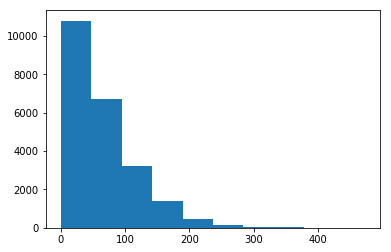

In [10]:
plt.hist(input_token_length)
plt.show()

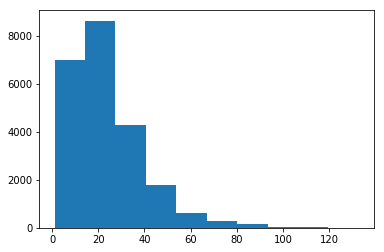

In [11]:
plt.hist(output_token_length)
plt.show()

In [ ]:
ls